# Visualizing the processes carried out by the trained RNN
## Requires tensorflow 1.13, python 3.7, scikit-learn, and pytorch 1.6.0
## You can download two pretrained RNNs from the associated OSF repository: https://osf.io/pf4u5/ or you can train a RNN using the RNN_gen.py script and assess it here.

## Importing the relevant modules, setting plotting variables, and importing the raw datasets

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import tensorflow as tf
import scipy
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.interpolation import rotate
from random import shuffle
from sklearn import svm
from scipy import ndimage
%pylab inline
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

plt.rc('axes', facecolor='#FFFFFF', edgecolor='black',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
fmnist = input_data.read_data_sets('fMNIST_data', one_hot=True)

Populating the interactive namespace from numpy and matplotlib
Extracting MNIST_data\train-images-idx3-ubyte.gz


C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Extracting fMNIST_data\train-images-idx3-ubyte.gz
Extracting fMNIST_data\train-labels-idx1-ubyte.gz
Extracting fMNIST_data\t10k-images-idx3-ubyte.gz
Extracting fMNIST_data\t10k-labels-idx1-ubyte.gz


## Functions defined

In [42]:
def im_scram(im,parts_h): # scramble parts_h*parts_h equal parts of the given image
    win_prop = parts_h
    dimsh = np.shape(im)
    im_new = np.zeros(dimsh)
    dimsh_win = np.floor(dimsh[0]/win_prop)
    n_cells = np.square(np.int(dimsh[0]/dimsh_win))
    cell_c = np.int(dimsh[0]/dimsh_win)
    ind_new = np.linspace(0,n_cells-1,n_cells).astype('int32')
    while np.mean(ind_new == np.linspace(0,n_cells-1,n_cells).astype('int32')) == 1:
        shuffle(ind_new)
    for i in range(n_cells):
        j = ind_new[i]
        im_new[np.int(np.mod(i,cell_c)*dimsh_win):np.int(np.mod(i,cell_c)*dimsh_win+dimsh_win),
               np.int(np.floor(i*1./cell_c*1.)*dimsh_win):np.int(np.floor(i*1./cell_c*1.)*dimsh_win+dimsh_win)] = im[
            np.int(np.mod(j,cell_c)*dimsh_win):np.int(np.mod(j,cell_c)*dimsh_win+dimsh_win),
            np.int(np.floor(j*1./cell_c*1.)*dimsh_win):np.int(np.floor(j*1./cell_c*1.)*dimsh_win+dimsh_win)]
    return im_new

def gen_images(n_imgs,n_set): # n_imgs required, set used (0 train, 1 val, 2 test) 8 objects in image (1 is intact), 2 levels of zoom, rotation and x/y pos for each object
    imgs_h = np.zeros([n_imgs,1,100,100])
    imgs_h1 = np.zeros([n_imgs,1,100,100])
    labs_h = np.zeros([n_imgs,20])
    pos_x_h = np.zeros([n_imgs,2])
    pos_y_h = np.zeros([n_imgs,2])
    size_h = np.zeros([n_imgs,2])
    rot_h = np.zeros([n_imgs,2])
    n_objs = 8
    for n_im in np.arange(n_imgs):
        inst_img = np.zeros([100,100])
        inst_img1 = np.zeros([100,100])
        obj_ord = np.linspace(0,n_objs-1,n_objs)
        dum_obj_ind = 4+np.random.randint(n_objs/2)
        dum_dat_ord = (np.random.random(8) < 0.5)*1.
        for i in np.arange(n_objs):
            if dum_dat_ord[i] == 0: # dataset M or F
                if n_set == 0:
                    dathh = mnist.train
                elif n_set == 1:
                    dathh = mnist.validation
                elif n_set == 2:
                    dathh = mnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            else:
                if n_set == 0:
                    dathh = fmnist.train
                elif n_set == 1:
                    dathh = fmnist.validation
                elif n_set == 2:
                    dathh = fmnist.test
                inst_obj_ind = np.random.randint(np.shape(dathh.images)[0])
                if i == dum_obj_ind:
                    inst_lab = 10 + np.where(dathh.labels[inst_obj_ind,:]==1)[0][0]
                inst_obj = np.reshape(dathh.images[inst_obj_ind,:],(28,28))
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # zoom 0.9 or 1.5
                inst_obj = zoom(inst_obj,0.9+(np.random.random(1)[0]-0.5)/5.) # zoom 0.8 to 1.
            else:
                inst_obj = zoom(inst_obj,1.5+(np.random.random(1)[0]-0.5)/5.) # zoom 1.4 to 1.6
            if i == dum_obj_ind:
                size_h[n_im,dumh111] = 1.
            dumh111 = (np.random.random(1)[0] > 0.5)*1
            if dumh111 == 0: # rotate 30 or -30
                inst_obj = rotate(inst_obj,30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate 25 to 35
            else:
                inst_obj = rotate(inst_obj,-30+(np.random.random(1)[0]-0.5)*2*5,reshape=False) # rotate -25 to -35
            if i == dum_obj_ind:
                rot_h[n_im,dumh111] = 1.
            if i != dum_obj_ind:
                inst_obj = im_scram(inst_obj,3) # scrambled if not object of interest
            if np.mod(obj_ord[i],4) == 0: # x_loc up or down
                x_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 1:
                x_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,0] = 1.
            elif np.mod(obj_ord[i],4) == 2:
                x_loc = np.int(np.round(25 + (np.random.random(1)[0]-0.5)*2*2.5)) # 25 +- 2.5
                y_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,0] = 1.
                    pos_x_h[n_im,1] = 1.
            elif np.mod(obj_ord[i],4) == 3:
                x_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                y_loc = np.int(np.round(75 + (np.random.random(1)[0]-0.5)*2*2.5)) # 75 +- 2.5
                if i == dum_obj_ind:
                    pos_y_h[n_im,1] = 1.
                    pos_x_h[n_im,1] = 1.
            inst_obj = (inst_obj-np.min(inst_obj))/(np.max(inst_obj)-np.min(inst_obj))
            # print(np.int(np.floor(np.shape(inst_obj)[0]/2)),np.int(np.ceil(np.shape(inst_obj)[0]/2)),np.shape(inst_obj)[0])
            inst_img[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
            if i == dum_obj_ind:
                inst_img1[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] = (1-inst_obj)*inst_img1[x_loc-np.int(np.floor(np.shape(inst_obj)[0]/2.)):x_loc+np.int(np.ceil(np.shape(inst_obj)[0]/2.)),y_loc-np.int(np.floor(np.shape(inst_obj)[1]/2.)):y_loc+np.int(np.ceil(np.shape(inst_obj)[1]/2.))] + (inst_obj)*inst_obj
        inst_img = (inst_img-np.min(inst_img))/(np.max(inst_img)-np.min(inst_img))
        inst_img1 = (inst_img1-np.min(inst_img1))/(np.max(inst_img1)-np.min(inst_img1))
        if np.isnan(np.min(inst_img)) or np.isnan(np.min(inst_img1)):
        	print('NaN in input')
        	exit(1)
        imgs_h[n_im,0,:,:] = inst_img
        imgs_h1[n_im,0,:,:] = inst_img1
        labs_h[n_im,inst_lab] = 1.
    return imgs_h,imgs_h1,labs_h,pos_x_h,pos_y_h,size_h,rot_h

In [43]:
# Defining the RNN class to be able to read out representations
class RNNet_all_fbr(nn.Module):
    def __init__(self, n_feats=8, ker_size=5,t_steps=3,b_flag=1,g_flag=1,l_flag=1,t_flag=1):
        super(RNNet_all_fbr, self).__init__()
        self.conv1 = nn.Conv2d(1, n_feats, ker_size)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(n_feats, n_feats*2, ker_size)
        self.fc1 = nn.Linear(n_feats*2 * 9 * 9, n_feats*16)
        self.fc2 = nn.Linear(n_feats*16*t_steps, 20)
        self.dropout = nn.Dropout(0.5)
        self.c1xb = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xb = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xb = nn.Linear(n_feats*16, 100*100)
        self.c1c1b = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1b = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1b = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2b = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2b = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1b = nn.Linear(n_feats*16, n_feats*16)
        self.c1xg = nn.ConvTranspose2d(n_feats,1,7,3) # in_channel, out_channel, kernel_size, stride, padding
        self.c2xg = nn.ConvTranspose2d(n_feats*2,1,20,10)
        self.fc1xg = nn.Linear(n_feats*16, 100*100)
        self.c1c1g = nn.Conv2d(n_feats, n_feats, ker_size, 1, 2)
        self.c2c1g = nn.ConvTranspose2d(n_feats*2,n_feats,16,10)
        self.fc1c1g = nn.Linear(n_feats*16, 96*96*n_feats)
        self.c2c2g = nn.Conv2d(n_feats*2, n_feats*2, ker_size, 1, 2)
        self.fc1c2g = nn.Linear(n_feats*16, 28*28*n_feats*2)
        self.fc1fc1g = nn.Linear(n_feats*16, n_feats*16)
        self.n_feats = n_feats
        self.t_steps = t_steps
        self.b_flag = b_flag
        self.g_flag = g_flag
        self.l_flag = l_flag
        self.t_flag = t_flag
    def forward(self, x):
        actvs = {}
        actvs[0] = {}
        actvs[1] = {}
        actvs[2] = {}
        actvs[3] = {}
        fb_acts = {}
        fb_acts[0] = {}
        fb_acts[1] = {}
        fb_acts[2] = {}
        fb_acts[3] = {}
        fb_acts_comb = {}
        fb_acts_comb[0] = {}
        fb_acts_comb[1] = {}
        fb_acts_comb[2] = {}
        fb_acts_comb[3] = {}
        for i in np.arange(2):
            fb_acts[0][i] = {}
            fb_acts[1][i] = {}
            fb_acts[2][i] = {}
            fb_acts[3][i] = {}
            fb_acts_comb[0][i] = {}
            fb_acts_comb[1][i] = {}
            fb_acts_comb[2][i] = {}
            fb_acts_comb[3][i] = {}
            for j in np.arange(3):
                fb_acts[0][i][j] = {}
                fb_acts[1][i][j] = {}
                if j > 0:
                    fb_acts[2][i][j-1] = {}
                    if j > 1:
                        fb_acts[3][i][j-2] = {}
        actvs[0][0] = F.relu(x) - F.relu(x-1)
        c1 = F.relu(self.conv1(actvs[0][0]))
        actvs[1][0] = self.pool(c1)
        c2 = F.relu(self.conv2(actvs[1][0]))
        actvs[2][0] = self.pool(c2)
        actvs[3][0] = F.relu(self.fc1(actvs[2][0].view(-1, self.n_feats*2 * 9 * 9)))
        actvs[4] = actvs[3][0]
        if self.t_steps > 0:
            for t in np.arange(self.t_steps-1):
                fb_acts[0][0][0][t] = self.t_flag*self.c1xb(actvs[1][t])
                fb_acts[0][0][1][t] = self.t_flag*self.c2xb(actvs[2][t])
                fb_acts[0][0][2][t] = self.t_flag*(self.fc1xb(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][0][t] = fb_acts[0][0][0][t] + fb_acts[0][0][1][t] + fb_acts[0][0][2][t]
                fb_acts[0][1][0][t] = self.t_flag*self.c1xg(actvs[1][t])
                fb_acts[0][1][1][t] = self.t_flag*self.c2xg(actvs[2][t])
                fb_acts[0][1][2][t] = self.t_flag*(self.fc1xg(actvs[3][t])).view(-1,1,100,100)
                fb_acts_comb[0][1][t] = fb_acts[0][1][0][t] + fb_acts[0][1][1][t] + fb_acts[0][1][2][t]
                dumh000 = (x + self.b_flag*(self.t_flag*(self.c1xb(actvs[1][t])+self.c2xb(actvs[2][t])+(self.fc1xb(actvs[3][t])).view(-1,1,100,100)))) * (1.+self.g_flag*self.t_flag*(self.c1xg(actvs[1][t])+self.c2xg(actvs[2][t])+(self.fc1xg(actvs[3][t])).view(-1,1,100,100)))
                actvs[0][t+1] = (F.relu(dumh000) - F.relu(dumh000-1))
                fb_acts[1][0][0][t] = self.l_flag*self.c1c1b(c1)
                fb_acts[1][0][1][t] = self.t_flag*self.c2c1b(actvs[2][t])
                fb_acts[1][0][2][t] = self.t_flag*(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][0][t] = fb_acts[1][0][0][t] + fb_acts[1][0][1][t] + fb_acts[1][0][2][t]
                fb_acts[1][1][0][t] = self.l_flag*self.c1c1g(c1)
                fb_acts[1][1][1][t] = self.t_flag*self.c2c1g(actvs[2][t])
                fb_acts[1][1][2][t] = self.t_flag*(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96)
                fb_acts_comb[1][1][t] = fb_acts[1][1][0][t] + fb_acts[1][1][1][t] + fb_acts[1][1][2][t]
                c1 = F.relu(self.conv1(actvs[0][t+1])+self.b_flag*(self.l_flag*self.c1c1b(c1)+self.t_flag*(self.c2c1b(actvs[2][t])+(self.fc1c1b(actvs[3][t])).view(-1,self.n_feats,96,96)))) * (1.+self.g_flag*(self.l_flag*self.c1c1g(c1)+self.t_flag*(self.c2c1g(actvs[2][t])+(self.fc1c1g(actvs[3][t])).view(-1,self.n_feats,96,96))))
                actvs[1][t+1] = self.pool(c1)
                fb_acts[2][0][0][t] = self.l_flag*self.c2c2b(c2)
                fb_acts[2][0][1][t] = self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][0][t] = fb_acts[2][0][0][t] + fb_acts[2][0][1][t]
                fb_acts[2][1][0][t] = self.l_flag*self.c2c2g(c2)
                fb_acts[2][1][1][t] = self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)
                fb_acts_comb[2][1][t] = fb_acts[2][1][0][t] + fb_acts[2][1][1][t]
                c2 = F.relu(self.conv2(actvs[1][t+1])+self.b_flag*(self.l_flag*self.c2c2b(c2)+self.t_flag*(self.fc1c2b(actvs[3][t])).view(-1,self.n_feats*2,28,28))) * (1.+self.g_flag*(self.l_flag*self.c2c2g(c2)+self.t_flag*(self.fc1c2g(actvs[3][t])).view(-1,self.n_feats*2,28,28)))
                actvs[2][t+1] = self.pool(c2)
                fb_acts[3][0][0][t] = self.l_flag*self.fc1fc1b(actvs[3][t])
                fb_acts[3][1][0][t] = self.l_flag*self.fc1fc1g(actvs[3][t])
                fb_acts_comb[3][0][t] = fb_acts[3][0][0][t]
                fb_acts_comb[3][1][t] = fb_acts[3][1][0][t]
                actvs[3][t+1] = F.relu(self.fc1(actvs[2][t+1].view(-1, self.n_feats*2 * 9 * 9))+self.b_flag*self.l_flag*self.fc1fc1b(actvs[3][t])) * (1.+self.g_flag*self.l_flag*self.fc1fc1g(actvs[3][t]))
                actvs[4] = torch.cat((actvs[4],actvs[3][t+1]),1)
        actvs[5] = torch.log(torch.clamp(F.softmax(self.fc2(actvs[4]),dim=1),1e-10,1.0))
        return actvs, fb_acts, fb_acts_comb

# Loading a RNN

In [44]:
n_feats = 8 # in Conv layer 1
ker_size = 5 # in Conv layer 1
b_h = 0 # bias modulation flag
g_h = 1 # gain modulation flag
l_h = 1 # lateral interactions flag
t_h = 1 # top-down interactions flag

net_num = 5

t_steps = 4

net_save_str = 'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num)

In [45]:
net = RNNet_all_fbr(n_feats,ker_size,t_steps,b_h,g_h)
net = net.float()
net.load_state_dict(torch.load('models/'+net_save_str+'.pth',map_location=torch.device('cpu')))
net.eval()

RNNet_all_fbr(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (c1xb): ConvTranspose2d(8, 1, kernel_size=(7, 7), stride=(3, 3))
  (c2xb): ConvTranspose2d(16, 1, kernel_size=(20, 20), stride=(10, 10))
  (fc1xb): Linear(in_features=128, out_features=10000, bias=True)
  (c1c1b): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (c2c1b): ConvTranspose2d(16, 8, kernel_size=(16, 16), stride=(10, 10))
  (fc1c1b): Linear(in_features=128, out_features=73728, bias=True)
  (c2c2b): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1c2b): Linear(in_features=128, out_features=12544, bias=True)
  (fc1fc1b): Linear(in_features=128, out_features=

## Visualizing the activations and the corresponding recurrent flows, at the Input

In [46]:
inputs_v,inputs_v_c,labels_v,_,_,_,_ = gen_images(5,1)
inputs_v = torch.from_numpy(inputs_v).float()
inputs_v_c = torch.from_numpy(inputs_v_c).float()

C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

In [47]:
outputs,_,out_fbr_comb = net(inputs_v.float())

True label: 18 ; Predicted label: 16
True label: 12 ; Predicted label: 14
True label: 14 ; Predicted label: 13
True label: 17 ; Predicted label: 19


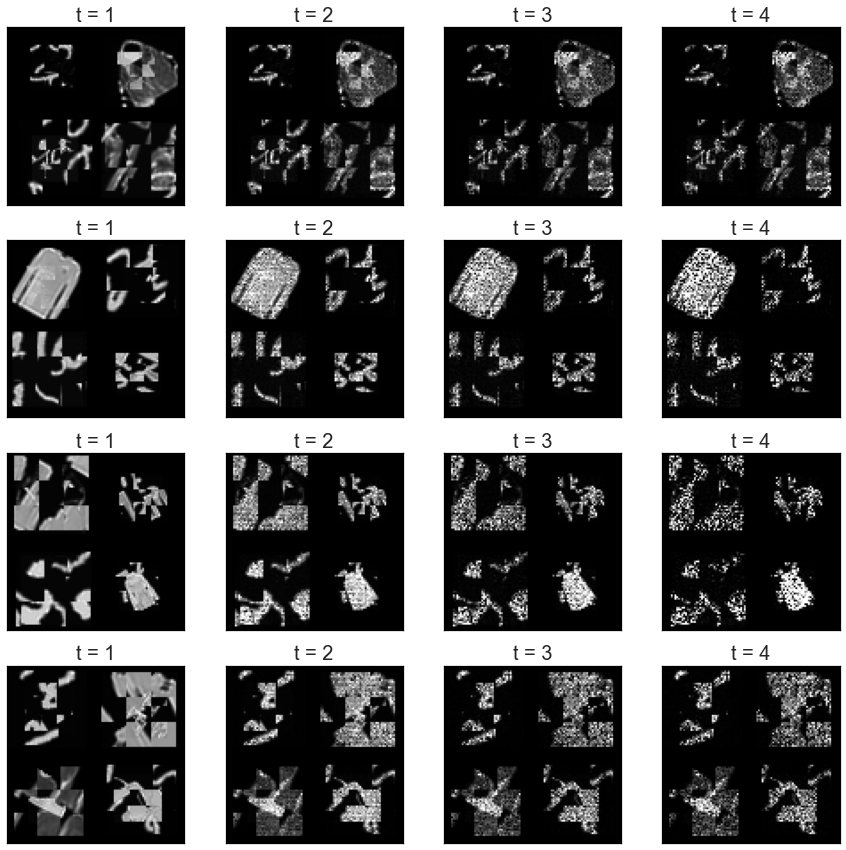

In [48]:
figure(figsize=(15,15))
for i in np.arange(4):
    print('True label:',np.where(labels_v[i,:])[0][0],'; Predicted label:',np.where(outputs[5][i].detach().numpy()==np.max(outputs[5][i].detach().numpy()))[0][0])
    for j in np.arange(t_steps):
        subplot(4,t_steps,(i)*t_steps+j+1)
        imshow(outputs[0][j][i,0,:,:].detach().numpy(),cmap='gray')
        xticks([])
        yticks([])
        title('t = '+str(j+1),fontsize=20)

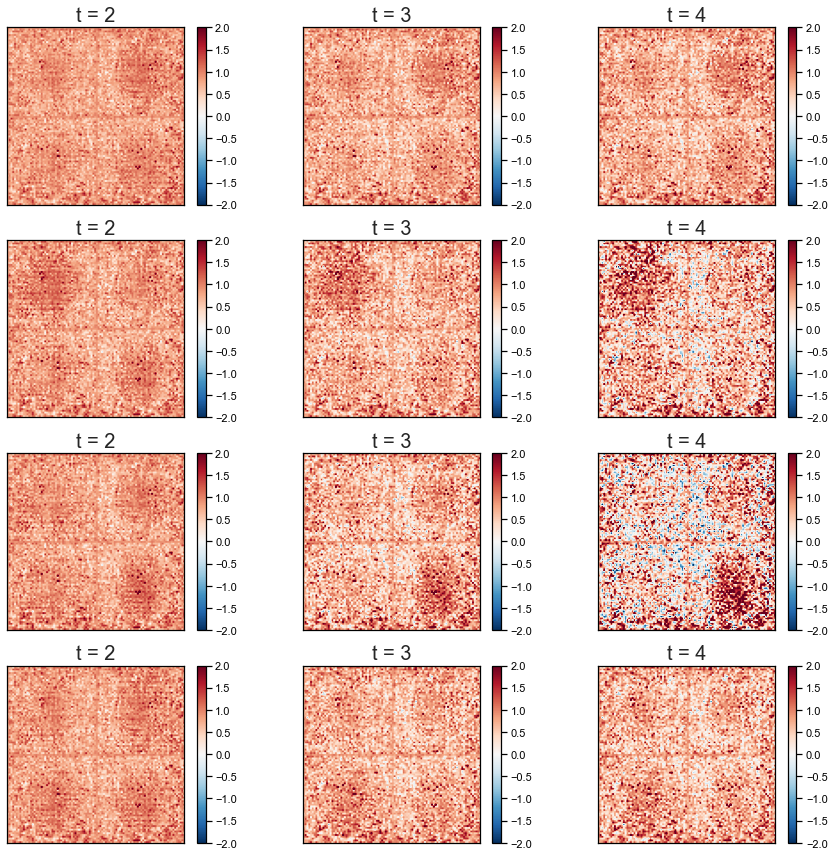

In [49]:
figure(figsize=(15,15))
for i in np.arange(4):
    for j in np.arange(t_steps-1):
        subplot(4,t_steps-1,(i)*(t_steps-1)+j+1)
        if g_h == 1:
            imshow(out_fbr_comb[0][1][j][i,0,:,:].detach().numpy()+1,cmap='RdBu_r')
        else:
            imshow(out_fbr_comb[0][0][j][i,0,:,:].detach().numpy()+1,cmap='RdBu_r')
        xticks([])
        yticks([])
        colorbar()
        clim([-2,2])
        title('t = '+str(j+2),fontsize=20)

## Decoding auxiliary variables and category from layer activations: Results

Output category accuracies:  0.07150000000000001
Auxiliary variable avg. decoding through time:  [0.115      0.12270833 0.125625   0.12416667]
Auxiliary variable avg. decoding through layer depth:  [0.1209375  0.11958333 0.12760417 0.119375  ]


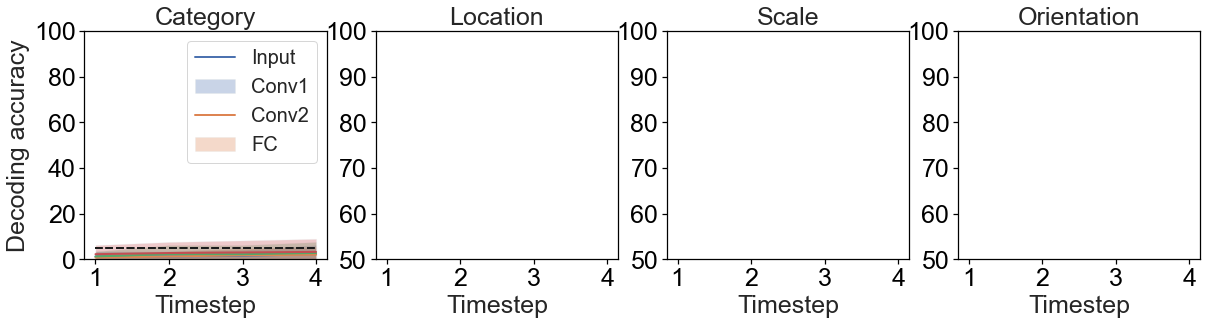

In [56]:
dec_acc1 = np.zeros([4,t_steps,5,2,5])
out_acc1 = np.zeros([5,2])
fbr_accs_all_comb1 = np.zeros([4,t_steps-1,2,5,5])

list = [4]
for net_num1 in list:
    dec_accs_str = 'dec_acc'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
#for net_num1 in np.arange(5):
#    dec_accs_str = 'analyses/'+'dec_acc'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
    with open(dec_accs_str, 'rb') as f:
        dec_acc = np.load(f)
        out_acc = np.load(f)
        fbr_accs_all_comb = np.load(f)
    dec_acc1[:,:,0,:,net_num1] = np.mean(dec_acc[:,:,0,:,:],3)
    dec_acc1[:,:,1,:,net_num1] = np.mean(np.mean(dec_acc[:,:,1:3,:,:],4),2)
    dec_acc1[:,:,2:,:,net_num1] = np.mean(dec_acc[:,:,3:,:,:],4)
    out_acc1[net_num1,:] = np.mean(out_acc,1)
    fbr_accs_all_comb1[:,:,:,0,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,0,:],3)
    fbr_accs_all_comb1[:,:,:,1,net_num1] = np.mean(np.mean(fbr_accs_all_comb[:,:,:,1:3,:],4),3)
    fbr_accs_all_comb1[:,:,:,2:,net_num1] = np.mean(fbr_accs_all_comb[:,:,:,3:,:],4)

var_names = ['Category','Location','Scale','Orientation']
figure(figsize=(20,4.2))
for i in np.arange(4):
    subplot(1,4,i+1)
    for j in np.arange(4):
        plot(np.arange(t_steps)+1,np.transpose(np.mean(dec_acc1[j,:,i,0,:],1))*100.)
        y = np.transpose(dec_acc1[j,:,i,0,:])*100.
        ci = 1.96 * np.std(y,0)/np.sqrt(5)
        fill_between(np.arange(t_steps)+1, (np.mean(y,0)-ci), (np.mean(y,0)+ci), alpha=.3)
    if i == 0:
        plot(np.arange(t_steps)+1,0*np.transpose(np.mean(dec_acc1[0:4,:,i,0,:],2))+5,'k--')
    xticks(np.arange(t_steps)+1,fontsize=25)
    yticks(fontsize=25)
    if i == 0:
        legend(['Input','Conv1','Conv2','FC'],fontsize=20)
        ylim([0,100])
        ylabel('Decoding accuracy',fontsize=25)
    else:
        ylim([50,100])
    tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
    title(var_names[i],fontsize=25)
    xlabel('Timestep',fontsize=25)
    
print('Output category accuracies: ',np.mean(out_acc1,0)[0])
print('Auxiliary variable avg. decoding through time: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),0))
print('Auxiliary variable avg. decoding through layer depth: ',np.mean(np.mean(np.mean(dec_acc1[:,:,1:4,0,:],3),2),1))

## Decoding auxiliary variables and category from the recurrent flows: Results

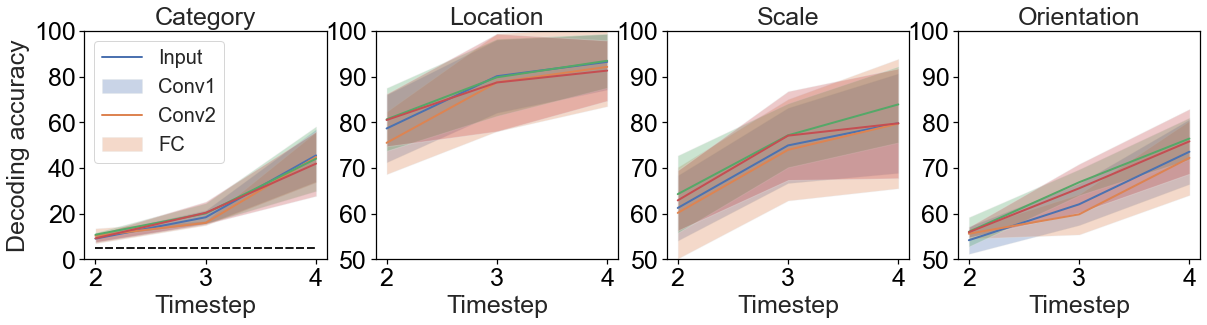

In [51]:
figure(figsize=(20,4.2))
for i in np.arange(4):
    subplot(1,4,i+1)
    for j in np.arange(4):
        plot(np.arange(t_steps-1)+2,np.transpose(np.mean(fbr_accs_all_comb1[j,:,1,i,:],1))*100.)
        y = np.transpose(fbr_accs_all_comb1[j,:,1,i,:])*100.
        ci = 1.96 * np.std(y,0)/np.sqrt(5)
        fill_between(np.arange(t_steps-1)+2, (np.mean(y,0)-ci), (np.mean(y,0)+ci), alpha=.3)
    if i == 0:
        plot(np.arange(t_steps-1)+2,0*np.transpose(np.mean(fbr_accs_all_comb1[0:4,:,1,i,:],2))+5,'k--')
    xticks(np.arange(t_steps-1)+2,fontsize=25)
    yticks(fontsize=25)
    if i == 0:
        legend(['Input','Conv1','Conv2','FC'],fontsize=20)
        ylim([0,100])
        ylabel('Decoding accuracy',fontsize=25)
    else:
        ylim([50,100])
    tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
    title(var_names[i],fontsize=25)
    xlabel('Timestep',fontsize=25)

## Perturbation analysis: Results

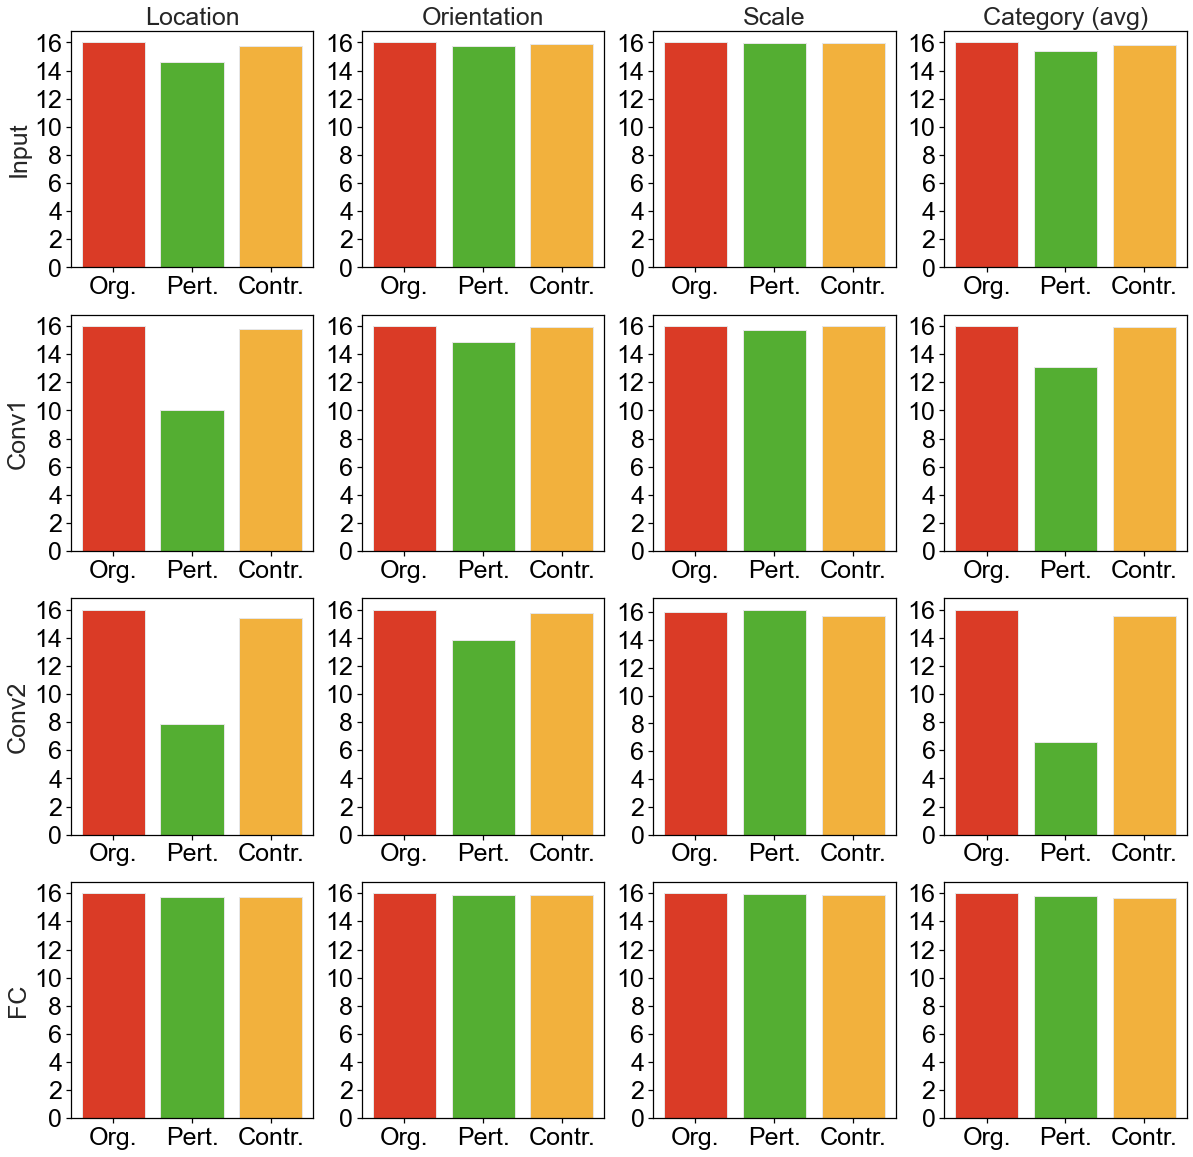

In [57]:
org_accs_h = np.zeros([5,1])
pert_accs_h = np.zeros([5,4,2,4,3])
pert_accs_cat_sep = np.zeros([5,2,2,4,3])
list = [4]
for net_num1 in list:
    dec_accs_str = 'fb_perturb'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
#for net_num1 in np.arange(5):
#    out_str = 'analyses/'+'fb_perturb-'+'rnn_bglt_'+str(b_h)+str(g_h)+str(l_h)+str(t_h)+'_t_'+str(t_steps)+'_num_'+str(net_num1+1)+'.npy'
    with open(out_str, 'rb') as f:
        original_accuracy = np.load(f)
        perturbed_accuracies = np.load(f)
    org_accs_h[net_num1] = np.mean(original_accuracy)*100
    pert_accs_h[net_num1,0,:,:,:] = np.mean(np.mean(perturbed_accuracies[0:2,:,:,:,:],4),0)*100
    pert_accs_h[net_num1,1:3,:,:,:] = np.mean(perturbed_accuracies[2:4,:,:,:,:],4)*100
    pert_accs_h[net_num1,3,:,:,:] = np.mean(np.mean(perturbed_accuracies[4:6,:,:,:,:],4),0)*100
    pert_accs_cat_sep[net_num1,0,:,:,:] = np.mean(np.mean(perturbed_accuracies[4:5,:,:,:,:],4),0)*100
    pert_accs_cat_sep[net_num1,1,:,:,:] = np.mean(np.mean(perturbed_accuracies[5:6,:,:,:,:],4),0)*100

pert_names = ['Location','Orientation','Scale','Category (avg)']
lay_names = ['Input','Conv1','Conv2','FC']
figure(figsize=(20,20))
for lay in np.arange(4):
    for pert in np.arange(4):
        subplot(4,4,lay*4+pert+1)
        bar(1,np.mean(org_accs_h),color='#DA3B26')
        bar(2,np.mean(pert_accs_h[:,pert,0,lay,2]),color='#54AE32')
        bar(3,np.mean(pert_accs_h[:,pert,1,lay,2]),color='#F2B13D')
        xticks(np.arange(3)+1,['Org.','Pert.','Contr.'],fontsize=25)
        yticks(fontsize=25)
        if lay == 0:
            title(pert_names[pert],fontsize=25)
        if pert == 0:
            ylabel(lay_names[lay],fontsize=25)
        tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)

C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


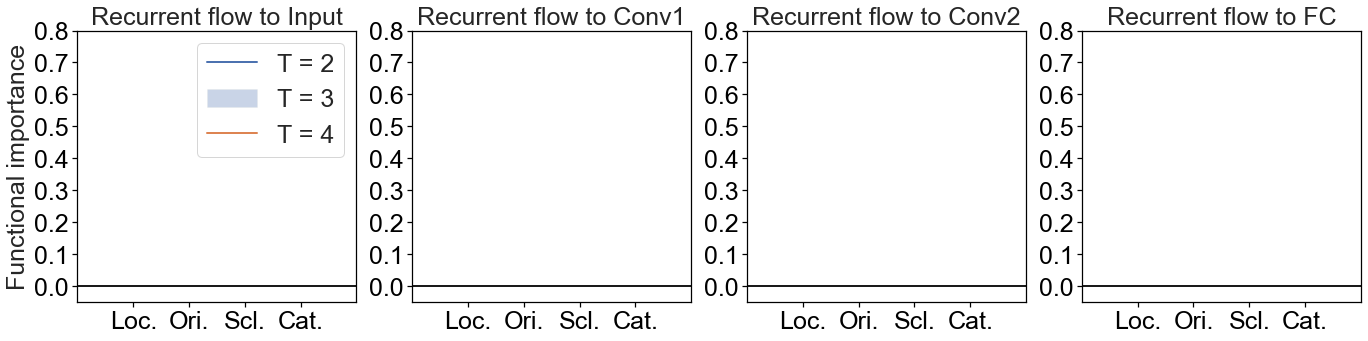

In [58]:
perturbed_relative = np.zeros([4,4,3])
pert_rel_se = np.zeros([4,4,3])
for lay in np.arange(4):
    for pert in np.arange(4):
        for th in np.arange(3):
            perturbed_relative[pert,lay,th] = np.mean((pert_accs_h[:,pert,1,lay,th] - pert_accs_h[:,pert,0,lay,th])/org_accs_h)
            pert_rel_se[pert,lay,th] = 1.96*np.std((pert_accs_h[:,pert,1,lay,th] - pert_accs_h[:,pert,0,lay,th])/org_accs_h)/np.sqrt(5)
figure(figsize=(23,5))
pert_names = ['Loc.','Ori.','Scl.','Cat.']
for lay in np.arange(4):
    subplot(1,4,lay+1)
    for th in np.arange(3):
        plot(np.arange(4)+1,perturbed_relative[:,lay,th])
        fill_between(np.arange(4)+1, (perturbed_relative[:,lay,th]-pert_rel_se[:,lay,th]), (perturbed_relative[:,lay,th]+pert_rel_se[:,lay,th]), alpha=.3)
    plot(np.arange(6),0*np.arange(6),'k-')
    xticks(np.arange(4)+1,pert_names,fontsize=25)
    yticks(fontsize=25)
    ylim([-.05,0.8])
    xlim([0,5])
    title('Recurrent flow to '+lay_names[lay],fontsize=25)
    if lay == 0:
        legend(['T = 2','T = 3','T = 4'],fontsize=25)
        ylabel('Functional importance',fontsize=25)
    tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
# plt.savefig('fig5.png', dpi=500)

### Functional importance as a function of perturbation within category domain or across domain

C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\thous\anaconda3\envs\RNN_explain\lib\site-pack

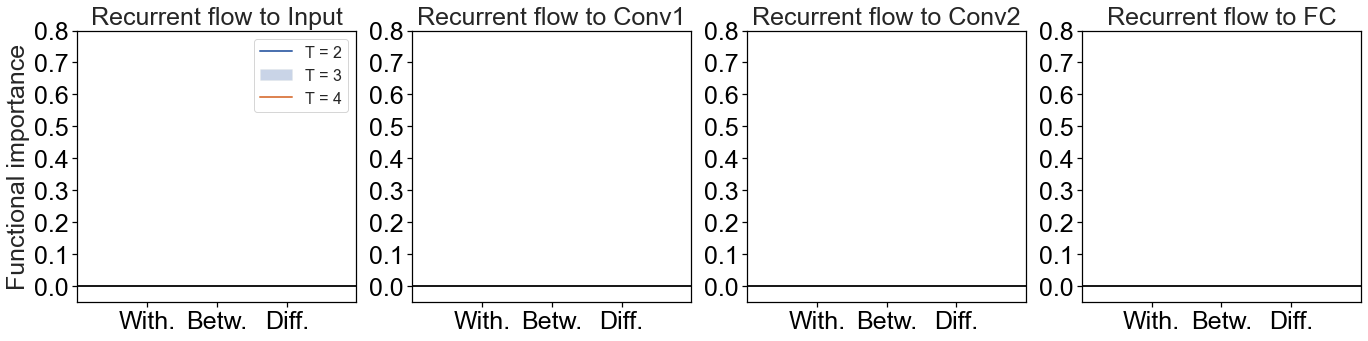

In [59]:
perturbed_relative = np.zeros([3,4,3])
pert_rel_se = np.zeros([3,4,3])
for lay in np.arange(4):
    for th in np.arange(3):
        for pert in np.arange(2):
            perturbed_relative[pert,lay,th] = np.mean((pert_accs_cat_sep[:,pert,1,lay,th] - pert_accs_cat_sep[:,pert,0,lay,th])/org_accs_h)
            pert_rel_se[pert,lay,th] = 1.96*np.std((pert_accs_cat_sep[:,pert,1,lay,th] - pert_accs_cat_sep[:,pert,0,lay,th])/org_accs_h)/np.sqrt(5)
        perturbed_relative[2,lay,th] = perturbed_relative[1,lay,th] - perturbed_relative[0,lay,th]
        pert_rel_se[2,lay,th] = 1.96*np.std((pert_accs_cat_sep[:,1,1,lay,th] - pert_accs_cat_sep[:,1,0,lay,th])/org_accs_h-(pert_accs_cat_sep[:,0,1,lay,th] - pert_accs_cat_sep[:,0,0,lay,th])/org_accs_h)/np.sqrt(5)
figure(figsize=(23,5))
for lay in np.arange(4):
    subplot(1,4,lay+1)
    for th in np.arange(3):
        plot(np.arange(3)+1,perturbed_relative[:,lay,th])
        fill_between(np.arange(3)+1, (perturbed_relative[:,lay,th]-pert_rel_se[:,lay,th]), (perturbed_relative[:,lay,th]+pert_rel_se[:,lay,th]), alpha=.3)
    plot(np.arange(5),0*np.arange(5),'k-')
    xticks(np.arange(3)+1,['With.','Betw.','Diff.'],fontsize=25)
    yticks(fontsize=25)
    ylim([-.05,0.8])
    xlim([0,4])
    title('Recurrent flow to '+lay_names[lay],fontsize=25)
    if lay == 0:
        legend(['T = 2','T = 3','T = 4'],fontsize=16)
        ylabel('Functional importance',fontsize=25)
    tick_params(axis=u'both', which=u'both',length=5,color='black',top=False, bottom=True, left=True, right=False)
# plt.savefig('fig5.png', dpi=500)